In [7]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 276.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 369.8 MB/s eta 0:00:00


In [2]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Dirs

In [31]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## Carol's runs
# logging_dir = "/n/holyscratch01/iaifi_lab/ccuesta/checkpoints/"

# run_name = "blooming-puddle-230"  # Has weird likelihoods
# run_name = "chocolate-cloud-122"  # The one in the paper
# run_name = "silver-breeze-231"  # Only rotations
# run_name = "hopeful-bush-231"  # Only translations

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/cosmology-augmentations-guidance-discriminative/"
logging_dir_base = "/n/holystore01/LABS/iaifi_lab/Users/smsharma/set-diffuser/logging/cosmology-augmentations-guidance/"
logging_dir = logging_dir_base
# run_name = "efficient-firefly-111"  # No translations or rotations
# run_name = "worldly-voice-112"  # Only translations
# run_name = "stilted-oath-118" # Both; longer run
# run_name = "blooming-waterfall-120"  # Different config; larger batch size etc
# run_name = "solar-pond-123"  # k=100, batch size 16
# run_name = "treasured-resonance-125"
# run_name = "peach-gorge-130"
run_name_base = "treasured-totem-200"  # Run with unconditional dropout
run_name = "treasured-totem-200"  # Run with unconditional dropout

## Load cluster run

In [32]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

config_file = "{}/{}/config.yaml".format(logging_dir_base, run_name_base)

with open(config_file, 'r') as file:
    config_base = yaml.safe_load(file)
    
config_base = ConfigDict(config_base)

In [12]:
# Load the dataset
train_ds, norm_dict = load_data(
        config_base.data.dataset,
        config_base.data.n_features,
        config_base.data.n_particles,
        config_base.training.batch_size,
        config_base.seed,
        shuffle=True,
        split="train",
        #**config_base.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [13]:
x, conditioning, mask = next(batches)
x = x[0]
conditioning = conditioning[0]
mask = mask[0]

In [14]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config_base.data.apply_pbcs = False
box_size = config_base.data.box_size if config_base.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config_base.data.unit_cell)) if config_base.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": config_base.data.box_size,
        "unit_cell": unit_cell,
    }
)

In [15]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config_base.score)
encoder_dict = FrozenDict(config_base.encoder)
decoder_dict = FrozenDict(config_base.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config_base.data.n_features,
        timesteps=config_base.vdm.timesteps,
        noise_schedule=config_base.vdm.noise_schedule,
        # noise_schedule="linear",
        noise_scale=config_base.vdm.noise_scale,
        d_t_embedding=config_base.vdm.d_t_embedding,
        gamma_min=config_base.vdm.gamma_min,
        gamma_max=config_base.vdm.gamma_max,
        score=config_base.score.score,
        score_dict=score_dict,
        embed_context=config_base.vdm.embed_context,
        d_context_embedding=config_base.vdm.d_context_embedding,
        n_classes=config_base.vdm.n_classes,
        use_encdec=config_base.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

1 devices visible
Params: 481,229


In [16]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [17]:
n_samples = 2
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config_base.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

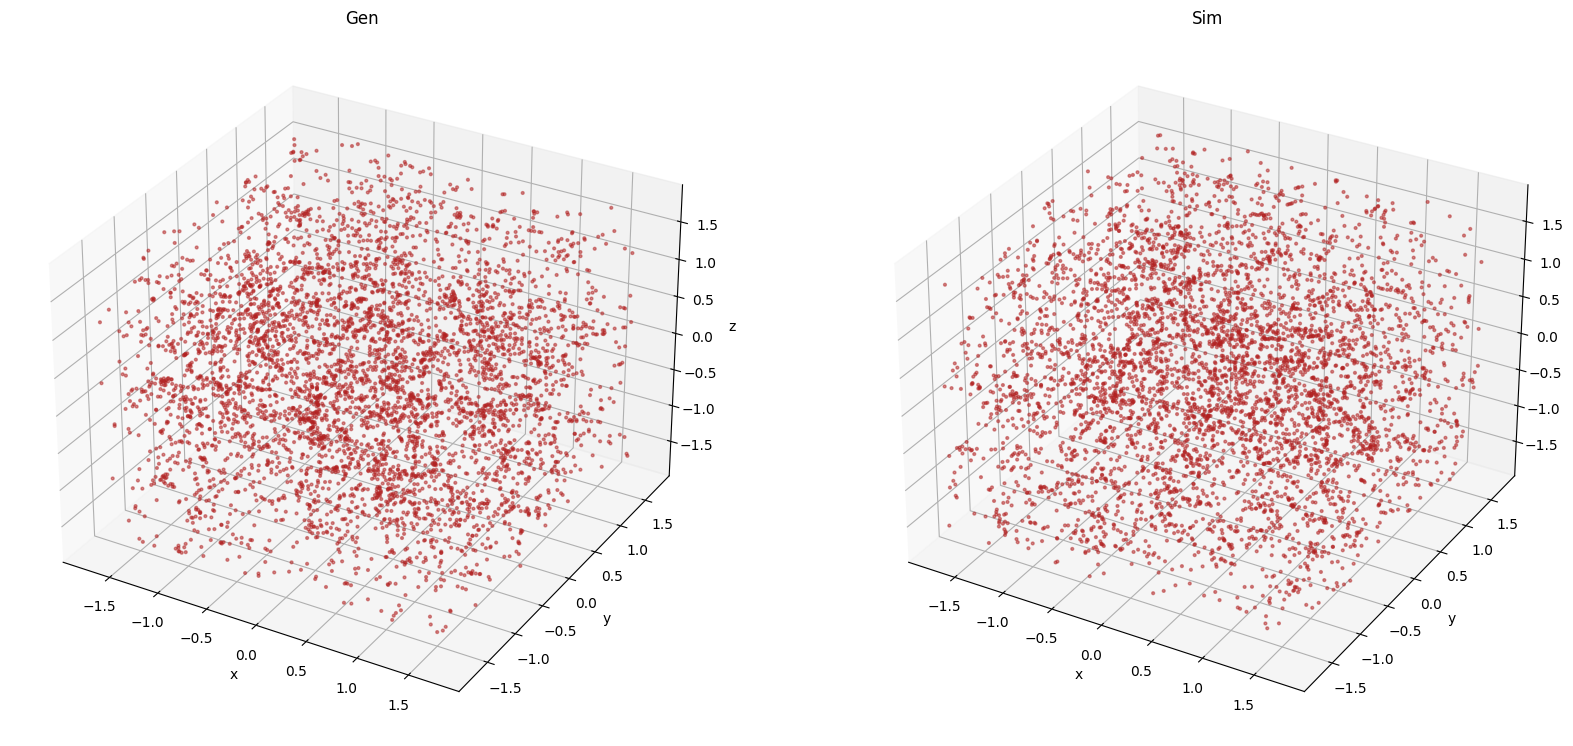

In [18]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood eval

In [19]:
from functools import partial

In [20]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20, unroll_loop=True):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)
    
    if not unroll_loop:
        
        def body_fun(i, val):
            loss, rng = val
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]), f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

        loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    else:
        
        loss_diff, rng = (np.zeros(x.shape[0]), rng)

        for i in range(steps):
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]), f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            loss_diff =  loss_diff + (new_loss * mask[..., None]).sum((-1, -2)) / steps

    return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)


In [23]:
@jax.jit
def likelihood(theta_test, x_test, n_samples=1, steps=30):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0]), steps=steps).mean()

In [24]:
idx = 4  # Has a bias in omega_m

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test)

Array(-21280.031, dtype=float32)

In [25]:
sigma_8_ary = np.linspace(0.6, 1.0, 50)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(theta_test, x_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s]


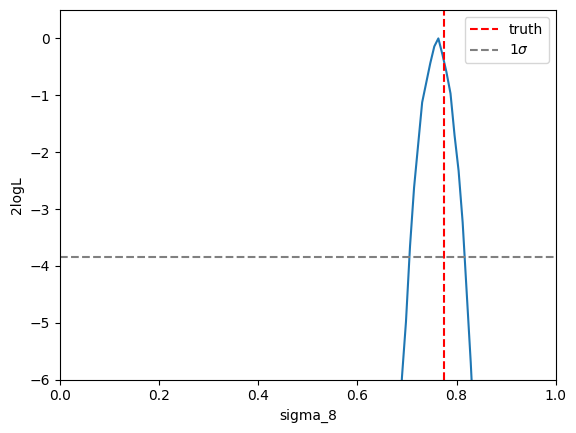

In [26]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()

In [27]:
omega_m_ary = np.linspace(0.1, 0.5, 50)

log_like = []

for omega_m in tqdm(omega_m_ary):
    theta_test = np.array([omega_m, conditioning[idx][1]])
    log_like.append(likelihood(theta_test, x_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]


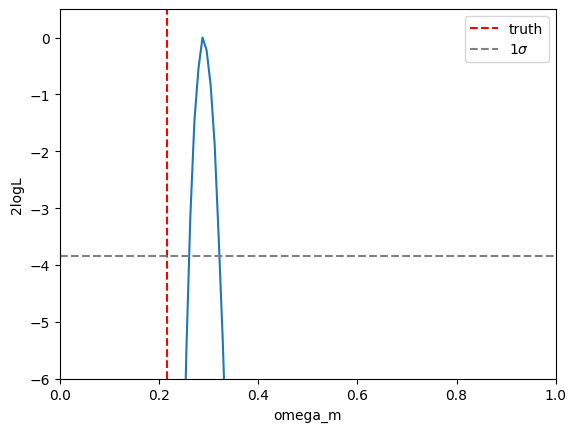

In [28]:
from scipy.stats import chi2

plt.plot(omega_m_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][0], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

## Calibration test

In [29]:
n_test = 20

log_like_cov = []
for idx in tqdm(range(n_test)):
    log_like = []
    x_test = x[idx]
    for omega_m in omega_m_ary:
        theta_test = np.array([omega_m, conditioning[idx][1]])
        log_like.append(likelihood(theta_test, x_test))
    log_like_cov.append(log_like)
log_like_cov = np.array(log_like_cov)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:29<00:00, 28.47s/it]


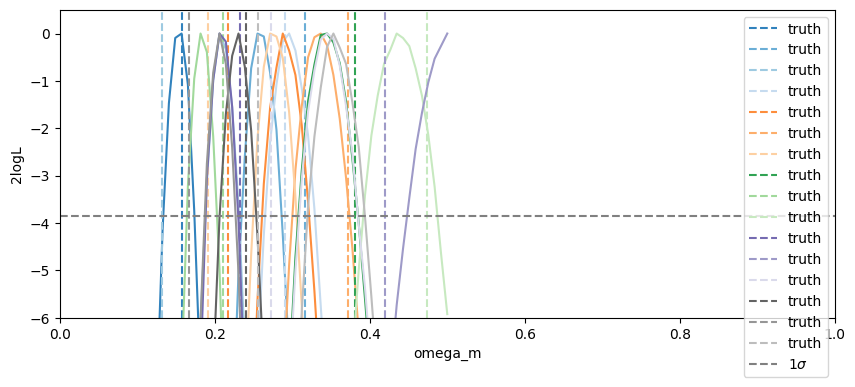

In [37]:
plt.figure(figsize=(10, 4))

i_ = 0
n_test_max = 16
for ic, idx in enumerate(range(i_,i_ + n_test_max)):
    if conditioning[idx][0] > 0.1:
        plt.plot(omega_m_ary, 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx]))), color=plt.cm.tab20c(ic / n_test_max))
        plt.axvline(conditioning[idx][0], ls='--', label="truth", color=plt.cm.tab20c(ic / n_test_max))
        # print(conditioning[idx][0])

plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

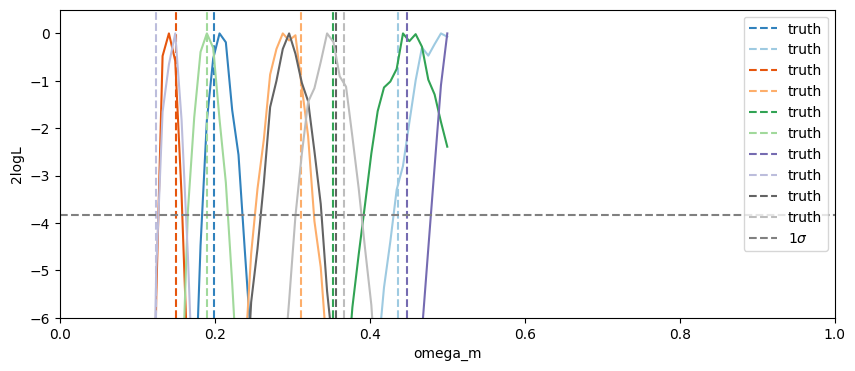

In [95]:
plt.figure(figsize=(10, 4))

i_ = 10
n_test_max = 10
for ic, idx in enumerate(range(i_,i_ + n_test_max)):
    if conditioning[idx][0] > 0.1:
        plt.plot(omega_m_ary, 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx]))), color=plt.cm.tab20c(ic / n_test_max))
        plt.axvline(conditioning[idx][0], ls='--', label="truth", color=plt.cm.tab20c(ic / n_test_max))

plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

## Discriminative loss

In [21]:
from tensorflow_probability.substrates import jax as tfp

In [22]:
# This should give us the evidence
likelihood(np.array([0., 0.]), x_test)

Array(-25646.332, dtype=float32)

In [38]:
@jax.jit
def likelihood(params, theta_test, x_test, n_samples=1, steps=4):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, params, rng, x_test, theta_test, np.ones_like(x_test[..., 0]), steps=steps).mean()

In [36]:
def m_log_posterior_estimate(params, x, theta):
    log_prior = tfp.distributions.Uniform(low=(0.1, 0.6), high=(0.5, 1.0)).log_prob(theta_test).sum()
    log_ev = likelihood(params, np.array([0., 0.]), x)
    log_like = likelihood(params, theta, x)
    return -(log_like + log_prior - log_ev)

m_log_posterior_estimate(restored_state.params, x_test, theta_test)

Array(49.304688, dtype=float32)

In [40]:
grad_discrim = jax.grad(m_log_posterior_estimate)(restored_state.params, x_test, theta_test)

## Sampling with PF-ODE

In [21]:
from models.diffusion_utils import gamma, sigma2
import diffrax as dfx

In [22]:
def single_sample_fn(vdm, params, conditioning, mask, data_shape, dt0, t1, t0, key):


    def int_beta(t):
        return np.log(1 + np.exp(-vdm.apply(params, t, method=vdm.gammat)))    
    
    def beta(t):
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return beta

    @jax.jit
    def drift(t, y, args):

        y = y[None, ...]
        t = np.atleast_1d(t)

        beta_t = beta(t)
        g_t = vdm.apply(params, t, method=vdm.gammat)
        sigma2_t = sigma2(g_t)
        
        f = -0.5 * beta_t * y 
        g2 = beta_t
                
        eps = vdm.apply(params, y, g_t, conditioning[None, ...], mask[None, ...], method=vdm.score_eval)
        
        score = -eps / np.sqrt(sigma2_t)
        return (f - 0.5 * g2 * score)[0]

    term = dfx.ODETerm(drift)
    solver = dfx.Heun()
    y1 = jax.random.normal(key, data_shape)
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

dt = 1e-2
key = jax.random.PRNGKey(4)
T = 1.
t0 = 0.

x_single_sample = single_sample_fn(vdm, restored_state.params, conditioning[0], mask[0], (5000, 3), dt, T, t0, key)

2023-08-13 21:51:37.521160: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.109 = pred[250000]{0} fusion(s32[1,250000,2]{2,1,0} %constant.3166), kind=kInput, calls=%fused_computation.109

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-08-13 21:51:37.706818: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.189264077s
Constant folding an instruction is taking > 1s:

  %fusion.109 = pred[250000]{0} fusion(s32[1,250000,2]{2,1,0} %constant.3166), kind=kInput, calls=%fused_computation.109

This isn't necessarily a bug; constant-folding is inherentl

Text(0.5, 0, 'z')

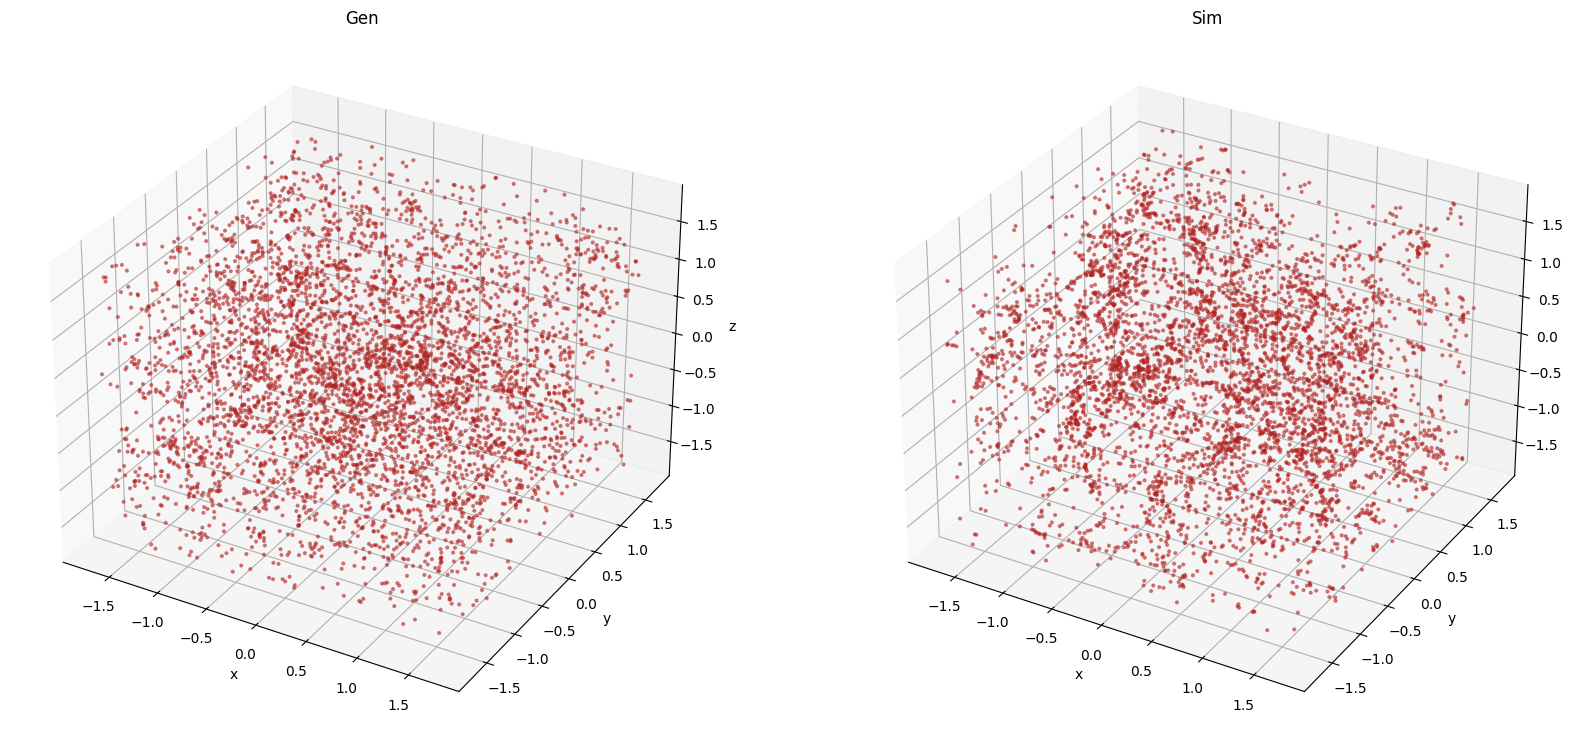

In [23]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_single_sample[:, 0], x_single_sample[:, 1], x_single_sample[:, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood evaluation with PF-ODE

See another implementation here: https://colab.research.google.com/drive/1SeXMpILhkJPjXUaesvzEhc3Ke6Zl_zxJ?usp=sharing#scrollTo=DfOkg5jBZcjF

Current issue: Trace estimator is extremely susceptible to RNG.

In [66]:
from diffrax import PIDController

@jax.jit
def likelihood(params, y, conditioning, mask, key, dt0):

    def int_beta(t):
        return np.log(1 + np.exp(-vdm.apply(params, t, method=vdm.gammat)))    
    
    def beta(t):
        _, beta = jax.jvp(int_beta, (t,), (np.ones_like(t),))
        return beta

    def drift(t, y):
        y = y[None, ...]
        t = np.atleast_1d(t)

        beta_t = beta(t)
        g_t = vdm.apply(params, t, method=vdm.gammat)
        sigma2_t = sigma2(g_t)
        
        f = -0.5 * beta_t * y 
        g2 = beta_t
                
        eps = vdm.apply(params, y, g_t, conditioning[None, ...], mask[None, ...], method=vdm.score_eval)
        
        score = -eps / np.sqrt(sigma2_t)
        return (f - 0.5 * g2 * score)[0]

    def logp(t, y, args):
        """ Approx. trace using Hutchinson's trace estimator.
        """
        y, _ = y
        (eps,) = args
        t = np.atleast_1d(t)
        
        fn = lambda y: drift(t, y)
        f, f_vjp = jax.vjp(fn, y)
        
        # Trace estimator
        (eps_dfdy,) = f_vjp(eps)
        logp = np.sum(eps_dfdy * eps)
        return f, logp

    term = dfx.ODETerm(logp)
    solver = dfx.Dopri5()

    ## Noise for Hutchinson trace estimator
    # eps = jax.random.normal(key, y.shape)  # Gaussian
    eps = jax.random.randint(key, y.shape, minval=0, maxval=2).astype(np.float32) * 2 - 1  # Rademacher
    delta_log_likelihood = 0.0
    y = (y, delta_log_likelihood)
    t_eps = 1e-3  # Start at small value for numerical stability
    g_1 = vdm.apply(params, 1., method=vdm.gammat)  # Get variance at T=1  
    sigma2_1 = sigma2(g_1)
    stepsize_controller = dfx.PIDController(atol=1e-3, rtol=1e-3)
    sol = dfx.diffeqsolve(term, solver, t_eps, 1., dt0, y, (eps,), stepsize_controller=stepsize_controller)
    (z,), (delta_log_likelihood,) = sol.ys
    log_prob = delta_log_likelihood + tfp.distributions.Normal(loc=0., scale=np.sqrt(sigma2_1)).log_prob(z).sum()
    return log_prob

In [67]:
idx = 0  # Has a bias in omega_m

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

key = jax.random.PRNGKey(43)

theta_test = np.array([Omega_m, sigma_8])
likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.1)

Array(-17380.012, dtype=float32)

In [68]:
key = jax.random.PRNGKey(54)

theta_test = np.array([Omega_m, sigma_8])
likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.1)

Array(-17464.541, dtype=float32)

In [60]:
sigma_8_ary = np.linspace(0.6, 1.0, 30)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(restored_state.params, x_test, theta_test, mask[0], key, 0.2))

100%|███████████████████████████████████████████████████████████| 30/30 [04:14<00:00,  8.49s/it]


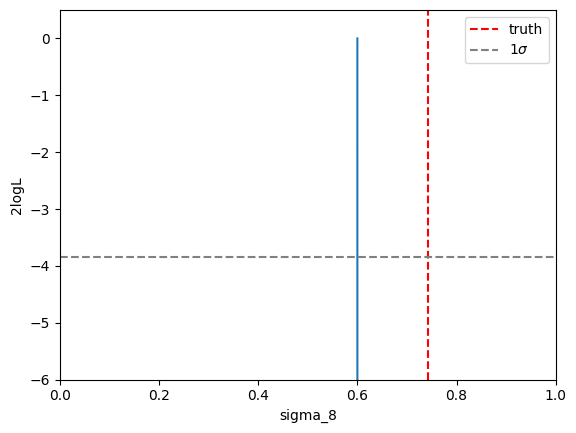

In [61]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()